# Vine Copulas with torchvine

This notebook demonstrates multivariate vine copula modeling:
1. Fitting vine copulas
2. Structure inspection
3. PDF and log-likelihood
4. Simulation
5. Rosenblatt transform (PIT)
6. Serialization
7. Higher-dimensional example

In [1]:
import torch
import torchvine as tv
import matplotlib.pyplot as plt
torch.manual_seed(42)

## 1. Fitting a Vine Copula

Create correlated data and fit a vine copula:

In [2]:
# Generate correlated data via a Gaussian copula structure
import math
n, d = 500, 4
z = torch.randn(n, d, dtype=torch.float64)
# Add correlation
rho = 0.6
for j in range(1, d):
    z[:, j] = rho * z[:, 0] + math.sqrt(1 - rho**2) * z[:, j]
# Transform to uniform margins
data = tv.to_pseudo_obs(z)
print(f'Data shape: {data.shape}')

Data shape: torch.Size([500, 4])


In [3]:
vine = tv.Vinecop.from_dimension(d)
vine.select(data)
print(vine.str())

E:\Agentic_AI\torchvine\torchvine\interpolation.py:101: UserWarning: torch.searchsorted(): input value tensor is non-contiguous, this will lower the performance due to extra data copy when converting non-contiguous tensor to contiguous, please use contiguous input value tensor if possible. This message will only appear once per program. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen/native/BucketizationUtils.h:34.)
  i = torch.searchsorted(grid, x0, right=True) - 1


<torchvine.Vinecop> Vinecop model with 4 variables
tree  edge   conditioned variables   conditioning variables   var_types      family  rotation            parameters       tau
   0     0                                                   ['c', 'c']    gaussian         0                  0.41      0.27
   0     1                                                   ['c', 'c']      gumbel         0                  1.34      0.25
   0     2                                                   ['c', 'c']      gumbel         0                  1.71      0.42
   1     0                                                   ['c', 'c']    gaussian         0                  0.26      0.17
   1     1                                                   ['c', 'c']    gaussian         0                  0.47      0.31
   2     0                                                   ['c', 'c']    gaussian         0                  0.45      0.29


## 2. Model Evaluation

In [4]:
ll = vine.loglik(data)
print(f'Log-likelihood: {ll:.2f}')
print(f'AIC:            {vine.aic(data):.2f}')
print(f'BIC:            {vine.bic(data):.2f}')
print(f'Parameters:     {vine.npars}')

Log-likelihood: 351.61
AIC:            -691.22
BIC:            -665.93
Parameters:     6.0


## 3. Simulation from a Vine

Simulated shape: torch.Size([2000, 4])


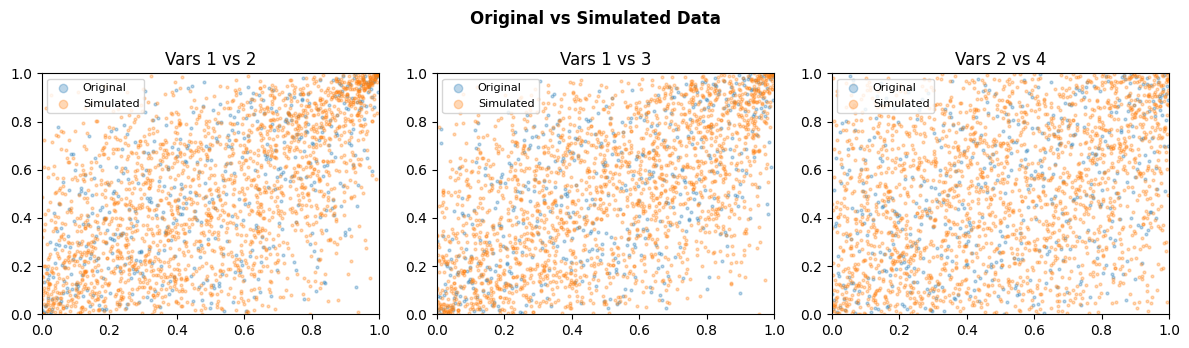

In [5]:
sim = vine.simulate(2000)
print(f'Simulated shape: {sim.shape}')

fig, axes = plt.subplots(1, 3, figsize=(12, 3.5))
pairs = [(0,1), (0,2), (1,3)]
for ax, (i, j) in zip(axes, pairs):
    ax.scatter(data[:, i].numpy(), data[:, j].numpy(), s=4, alpha=0.3, label='Original')
    ax.scatter(sim[:, i].numpy(), sim[:, j].numpy(), s=4, alpha=0.3, label='Simulated')
    ax.set_title(f'Vars {i+1} vs {j+1}')
    ax.legend(fontsize=8, markerscale=3)
    ax.set_xlim(0, 1); ax.set_ylim(0, 1)
plt.suptitle('Original vs Simulated Data', fontweight='bold')
plt.tight_layout()
plt.show()

## 4. Rosenblatt Transform (Probability Integral Transform)

The Rosenblatt transform converts data to independent uniforms if the model is correct:

PIT shape: torch.Size([500, 4])


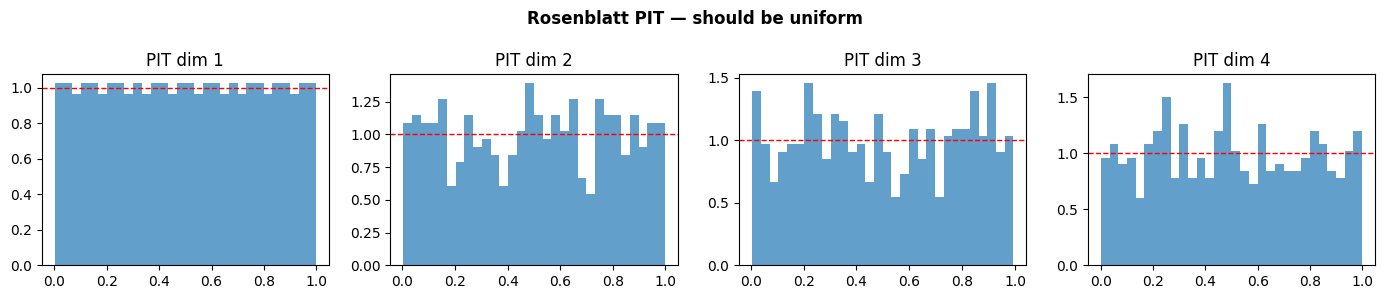

In [6]:
pit = vine.rosenblatt(data)
print(f'PIT shape: {pit.shape}')

fig, axes = plt.subplots(1, d, figsize=(14, 3))
for j in range(d):
    axes[j].hist(pit[:, j].numpy(), bins=30, density=True, alpha=0.7)
    axes[j].axhline(1.0, color='r', ls='--', lw=1)
    axes[j].set_title(f'PIT dim {j+1}')
plt.suptitle('Rosenblatt PIT — should be uniform', fontweight='bold')
plt.tight_layout()
plt.show()

## 5. Vine Structure

In [7]:
print('Order:', vine.order)
print('R-vine matrix:')
print(vine.structure.matrix)

Order: [4, 3, 2, 1]
R-vine matrix:
tensor([[2, 3, 4, 1],
        [3, 4, 2, 0],
        [4, 3, 0, 0],
        [4, 0, 0, 0]])


## 6. D-vine and C-vine Structures

You can fix the vine structure type before fitting:

In [8]:
dvine = tv.Vinecop.from_structure(structure=tv.DVineStructure(list(range(1, d+1))))
dvine.select(data)
print('D-vine:', dvine.str()[:200], '...')

D-vine: <torchvine.Vinecop> Vinecop model with 4 variables
tree  edge   conditioned variables   conditioning variables   var_types      family  rotation            parameters       tau
   0     0              ...


## 7. Serialization

Save and reload vine copula models:

In [9]:
import json
json_dict = vine.to_json()
json_str = json.dumps(json_dict, indent=2, default=str)
print(json_str[:300], '...')

vine2 = tv.Vinecop.from_json(json_dict)
print(f'\nReloaded vine dim: {vine2.dim}')
print(f'Log-lik match: {abs(vine.loglik(data) - vine2.loglik(data)) < 1e-10}')

{
  "structure": {
    "order": [
      4,
      3,
      2,
      1
    ],
    "array": {
      "d": 4,
      "t": 3,
      "data": [
        [
          2,
          3,
          4
        ],
        [
          3,
          4
        ],
        [
          4
        ]
      ]
    }
  },
  "pair c ...

Reloaded vine dim: 4
Log-lik match: True


## 8. Higher-Dimensional Example

In [10]:
d_high = 8
data_high = tv.to_pseudo_obs(torch.randn(1000, d_high, dtype=torch.float64))

vine_high = tv.Vinecop.from_dimension(d_high)
vine_high.select(data_high, controls=tv.FitControlsVinecop(
    family_set=tv.parametric,
))
print(f'Dimension: {vine_high.dim}')
print(f'Parameters: {vine_high.npars}')
print(f'Log-likelihood: {vine_high.loglik(data_high):.2f}')
print(f'AIC: {vine_high.aic(data_high):.2f}')

Dimension: 8
Parameters: 28.0
Log-likelihood: 25.12
AIC: 5.76


---

**Next:** See [04_kde1d_and_stats.ipynb](04_kde1d_and_stats.ipynb) for KDE and dependence measure demos.